## Full Version

In [1]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.preprocessing import image
from keras.engine import Layer
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate, Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
import glob
from PIL import Image
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [8]:
def make_square(im, min_size=256, fill_color=(255, 255, 255, 0)):
    x, y = im.size
    #min_size = x if x > y else y
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    new_im.thumbnail((min_size,min_size), Image.ANTIALIAS)
    return new_im

In [10]:
X = []
for i, filepath in enumerate(glob.glob('dataset/test_one_class/bear/train/*')):
    im = load_img(filepath)
    im = im.resize((256,256), Image.ANTIALIAS)
#     im = make_square(im)
    X.append(img_to_array(im))
X = np.array(X, dtype=float)
Xtrain = 1./255*X

In [ ]:
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.get_default_graph()

Instructions for updating:
Colocations handled automatically by placer.


In [35]:
embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

In [36]:
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
batch_size = 10

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)


#Train model
tensorboard = TensorBoard(log_dir="./board")
model.compile(optimizer='rmsprop', loss='mse')
model.fit_generator(image_a_b_gen(batch_size), callbacks=[tensorboard], epochs=100, steps_per_epoch=20)

Epoch 1/100
20/20 [==============================] - 26s 1s/step - loss: 0.8833
Epoch 2/100
20/20 [==============================] - 24s 1s/step - loss: 0.9276
Epoch 3/100
20/20 [==============================] - 24s 1s/step - loss: 0.9267
Epoch 4/100
20/20 [==============================] - 24s 1s/step - loss: 0.9274
Epoch 5/100
20/20 [==============================] - 24s 1s/step - loss: 0.9276
Epoch 6/100
20/20 [==============================] - 24s 1s/step - loss: 0.6561
Epoch 7/100
20/20 [==============================] - 24s 1s/step - loss: 0.0344
Epoch 8/100
20/20 [==============================] - 24s 1s/step - loss: 0.0087
Epoch 9/100
20/20 [==============================] - 24s 1s/step - loss: 0.0085
Epoch 10/100
20/20 [==============================] - 24s 1s/step - loss: 0.0086
Epoch 11/100
20/20 [==============================] - 24s 1s/step - loss: 0.0086
Epoch 12/100
20/20 [==============================] - 24s 1s/step - loss: 0.0199
Epoch 13/100
20/20 [=================

In [28]:
## save model
model_json = model.to_json()
with open("model/prototype_2.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model/prototype_2_weights.h5")

FileNotFoundError: [Errno 2] No such file or directory: 'model/prototype_2.json'

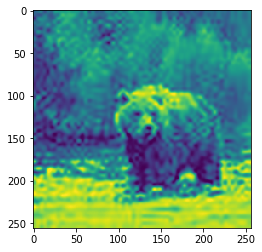

In [44]:
## test model
color_me = []
test_im = load_img("dataset/test_one_class/bear/test/n02132136_484.JPEG")
# test_im = make_square(test_im)
test_im = test_im.resize((256,256), Image.ANTIALIAS)
test_im = rgb2lab(test_im)
test_im = test_im[:,:,0]
plt.imshow(test_im)

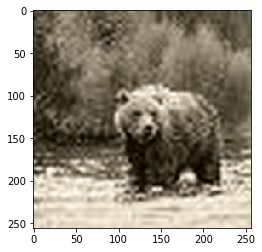

In [38]:
color_me.append(img_to_array(test_im))
color_me = np.array(color_me, dtype=float)
gray_me = gray2rgb(rgb2gray(1./255*color_me))
color_me_embed = create_inception_embedding(gray_me)
color_me = rgb2lab(1./255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

output = model.predict([color_me, color_me_embed])
output = output * 128

cur = np.zeros((256,256,3))
cur[:,:,0] = color_me[0][:,:,0]
cur[:,:,1:] = output[0]

plt.imshow(lab2rgb(cur), interpolation='nearest')

In [39]:
array_to_img(color_me)

ValueError: Expected image array to have rank 3 (single image). Got array with shape: (1, 256, 256, 1)